## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import XLNetTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5 as TextDataset
from xlnet import CustomXLNet
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12.3 s, sys: 129 ms, total: 12.4 s
Wall time: 12.7 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

## Training model

In [8]:
device = 'cuda'
pretrained_model = 'siamese_xlnet_1'
head_model_name = 'siamese_xlnet_1_head'
model_name = 'siamese_xlnet_1_comb'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [9]:
def load_model(checkpoint_file, model):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def get_pretrained_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomXLNet(256, cat_features_train.shape[1])
    load_model(checkpoint_file, model)
    return model

def load_head(model, fold_id):
    checkpoint_file = f'{checkpoint_dir}{head_model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model.head)

def save_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    torch.save({'model_state_dict': model.state_dict()}, checkpoint_file)
    
def load_saved_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model)

In [10]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    
    model = get_pretrained_model(fold_id)
    load_head(model, fold_id)
    model.half()
    save_model(model)
    load_saved_model(model)
    model.float()
    
    oofs[valid_index] = infer(model, valid_loader, None, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    del model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

Fold 1 started at Sun Feb  2 17:03:29 2020



Averaged Val. score: 0.42467129193439696
Fold 2 started at Sun Feb  2 17:04:30 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Averaged Val. score: 0.42613783512083825
Fold 3 started at Sun Feb  2 17:05:28 2020



Averaged Val. score: 0.41227403733594437
Fold 4 started at Sun Feb  2 17:06:26 2020



Averaged Val. score: 0.3996893122287206
Fold 5 started at Sun Feb  2 17:07:26 2020



Averaged Val. score: 0.4078385888453709
Fold 6 started at Sun Feb  2 17:08:23 2020



Averaged Val. score: 0.39916587395946473
Fold 7 started at Sun Feb  2 17:09:21 2020



Averaged Val. score: 0.4157742315971419
Fold 8 started at Sun Feb  2 17:10:19 2020



Averaged Val. score: 0.4143046989983007
Fold 9 started at Sun Feb  2 17:11:19 2020



Averaged Val. score: 0.41032981447383127
Fold 10 started at Sun Feb  2 17:12:17 2020



Averaged Val. score: 0.42401789847203053
OOF score: 0.41398949926739625


In [11]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.4805757154057279
5 4 0.463500051451823
7 8 0.5088578718483528
9 32 0.13216292111113287
11 8 0.7564399697966301
12 4 0.5451920474703457
13 4 0.30928911304921525
14 4 0.6230769918537882
15 4 0.5990059708575122
19 64 0.22463642966984484
21 16 0.24624124261114633


In [12]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4,  8, 32,  8,  4,  4,  4,  4, 64, 16]),
 array([ 2,  5,  7,  9, 11, 12, 13, 14, 15, 19, 21]))

In [13]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [14]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.413989
CV unique rows,0.376808
CV ignoring hard targets,0.437868
CV unique rows ignoring hard targets,0.398173
CV w rounding,0.448000
CV unique rows w rounding,0.421965
CV ignoring hard targets w rounding,0.467257
CV unique rows ignoring hard targets w rounding,0.436972


In [15]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.417944
CV unique rows,0.380868
CV ignoring hard targets,0.437868
CV unique rows ignoring hard targets,0.398173
CV w rounding,0.448830
CV unique rows w rounding,0.421965
CV ignoring hard targets w rounding,0.467257
CV unique rows ignoring hard targets w rounding,0.436972


In [16]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [17]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.822933,0.635381,0.325053,0.675632,0.466679,0.340159,0.652108,0.557256,0.075991,0.006959,0.680281,0.100777,0.241274,0.030341,0.009841,0.288096,0.145075,0.101709,0.472120,0.000942,0.774302,0.904171,0.562687,0.962505,0.956657,0.723187,0.184730,0.095440,0.797512,0.786723
1,0.829782,0.607702,0.045492,0.636003,0.920836,0.695209,0.606598,0.667967,0.372692,0.000835,0.262280,0.067185,0.743044,0.004364,0.745573,0.038911,0.085981,0.067641,0.473302,0.006428,0.758551,0.528017,0.280284,0.734528,0.777305,0.349777,0.026871,0.023037,0.455514,0.742892
2,0.618597,0.313556,0.007230,0.686728,0.736144,0.847997,0.461695,0.246745,0.124316,0.002027,0.419401,0.145505,0.003340,0.003130,0.001644,0.238346,0.728933,0.224330,0.169221,0.000082,0.547219,0.904457,0.648646,0.939859,0.919645,0.757459,0.662222,0.268065,0.569031,0.772413
3,0.832642,0.720184,0.062536,0.866209,0.892301,0.942631,0.546771,0.584924,0.329871,0.001004,0.130934,0.964111,0.019720,0.007254,0.114983,0.025791,0.032298,0.092152,0.430140,0.001760,0.772592,0.871355,0.706666,0.900012,0.920274,0.751031,0.023305,0.072053,0.841118,0.584669
4,0.780540,0.747321,0.001930,0.611868,0.820013,0.898422,0.413592,0.399618,0.220903,0.000378,0.336542,0.614871,0.000967,0.000332,0.000292,0.001947,0.910828,0.320043,0.083820,0.000010,0.778064,0.777336,0.403653,0.861954,0.845730,0.531118,0.905601,0.244271,0.046456,0.663537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.860152,0.489618,0.121414,0.783932,0.671265,0.776123,0.593214,0.630377,0.582856,0.003473,0.534595,0.950970,0.088136,0.475093,0.005740,0.078428,0.008934,0.036251,0.763994,0.004952,0.688356,0.924071,0.762696,0.937719,0.922783,0.760716,0.095459,0.145475,0.921572,0.718298
6075,0.881620,0.234716,0.092364,0.445075,0.490142,0.238959,0.773142,0.772624,0.039188,0.002111,0.698175,0.005193,0.005207,0.005547,0.000848,0.007433,0.792726,0.362128,0.180365,0.000036,0.733293,0.835378,0.536209,0.911663,0.926105,0.600150,0.870855,0.340762,0.236390,0.870200
6076,0.597486,0.393180,0.004287,0.688461,0.721065,0.922097,0.387686,0.262898,0.123063,0.003136,0.453030,0.622678,0.001035,0.000349,0.000401,0.003140,0.844270,0.344163,0.152432,0.000040,0.467676,0.562916,0.364233,0.786277,0.765965,0.342805,0.674273,0.204328,0.476589,0.443577
6077,0.875817,0.664933,0.845052,0.293157,0.172283,0.084579,0.620094,0.752506,0.576325,0.000347,0.952881,0.672309,0.072526,0.040115,0.000978,0.014278,0.012822,0.100825,0.655761,0.000009,0.899726,0.767283,0.643241,0.897510,0.908963,0.671184,0.015709,0.081304,0.835495,0.828410


In [18]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.391370
question_body_critical                   0.621514
question_conversational                  0.415317
question_expect_short_answer             0.296397
question_fact_seeking                    0.368204
question_has_commonly_accepted_answer    0.426221
question_interestingness_others          0.360524
question_interestingness_self            0.505355
question_multi_intent                    0.584892
question_not_really_a_question           0.090687
question_opinion_seeking                 0.479701
question_type_choice                     0.743564
question_type_compare                    0.366402
question_type_consequence                0.188460
question_type_definition                 0.362661
question_type_entity                     0.457491
question_type_instructions               0.781354
question_type_procedure                  0.373763
question_type_reason_explanation         0.669627
question_type_spelling                   0.068704


In [19]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.068704,3.0
question_not_really_a_question,0.090687,5.0
answer_plausible,0.143726,9.0
answer_relevance,0.173922,9.0
question_type_consequence,0.188460,5.0
answer_well_written,0.225458,9.0
answer_helpful,0.243791,9.0
question_expect_short_answer,0.296397,5.0
answer_type_procedure,0.306917,5.0
question_interestingness_others,0.360524,9.0


In [20]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

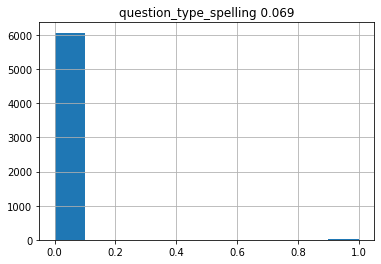

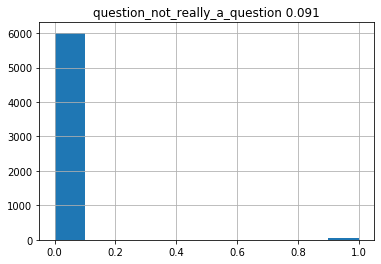

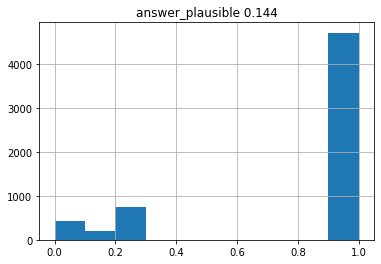

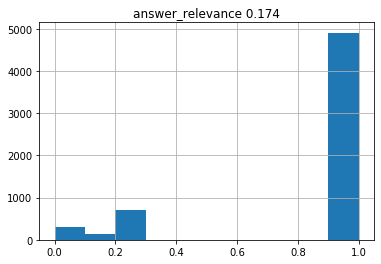

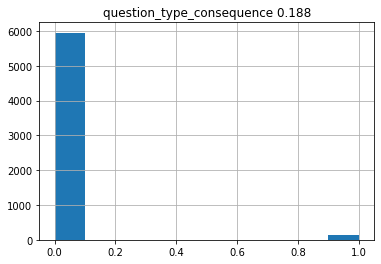

In [21]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


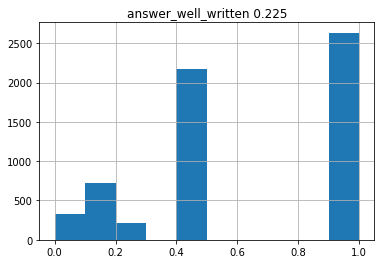

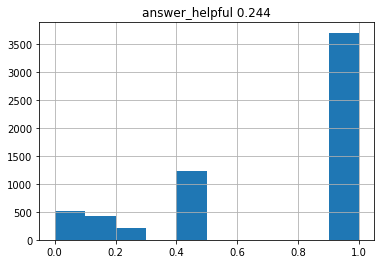

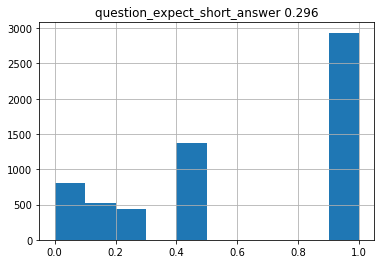

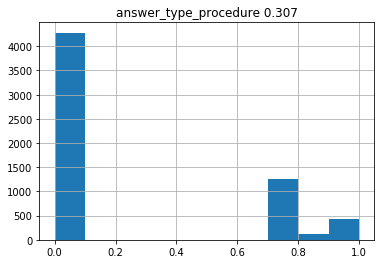

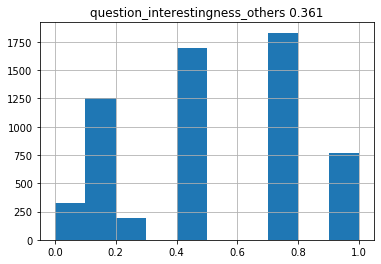

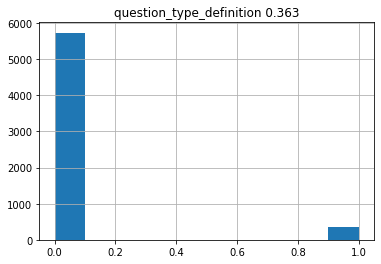

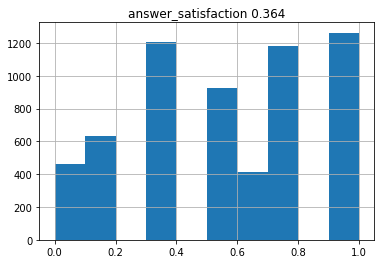

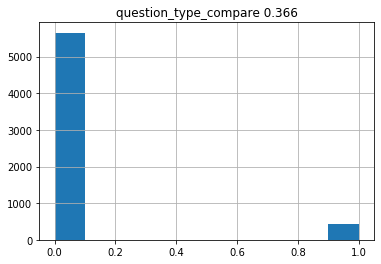

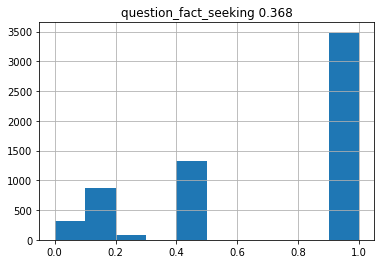

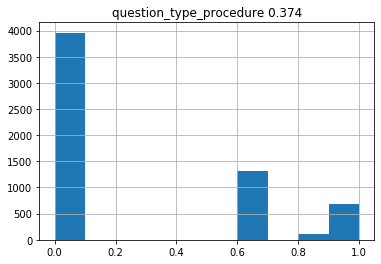

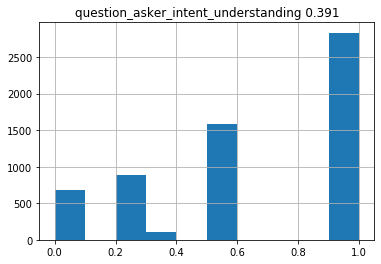

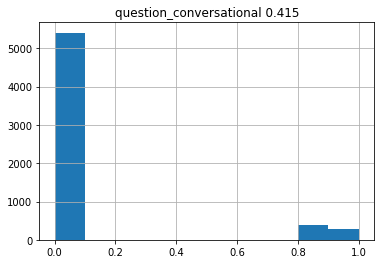

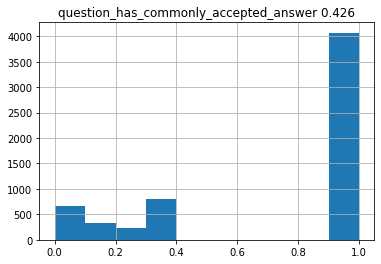

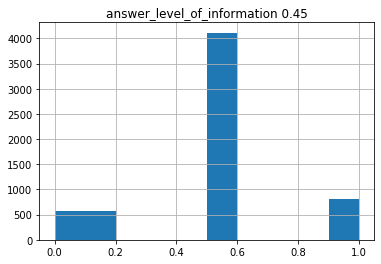

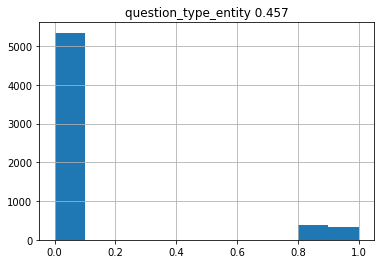

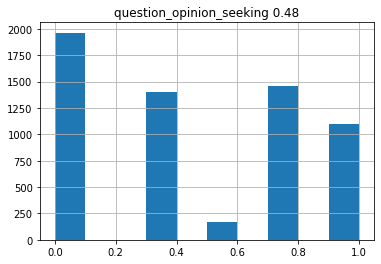

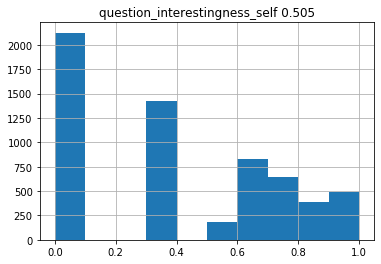

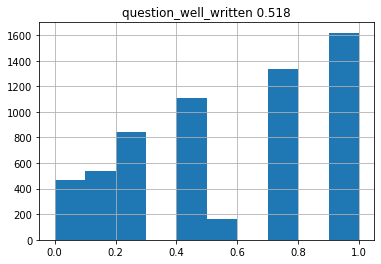

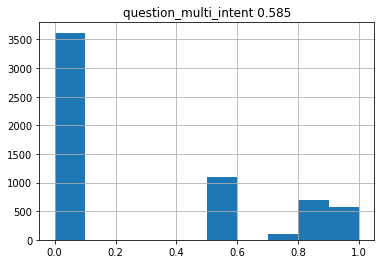

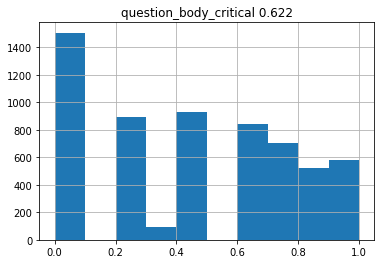

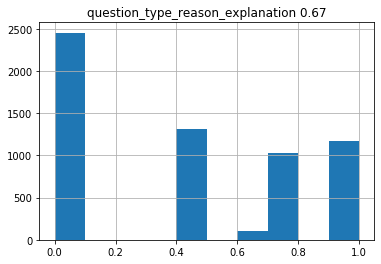

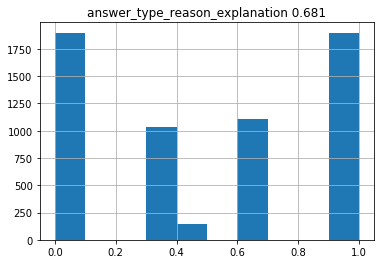

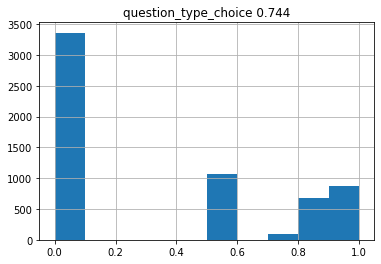

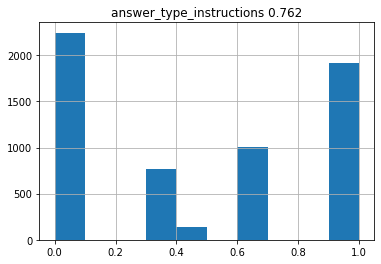

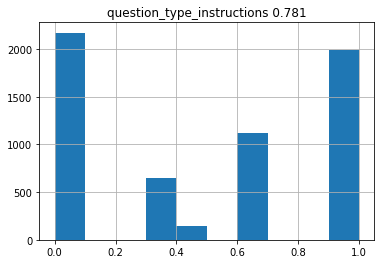

In [22]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')